In [18]:
import numpy as np
from preprocess import preprocess_data
from embeddings import Embeddings
from curate_using_LCA import curate_using_LCA, generate_wgtr_calibration_ground_truth, generate_ground_truth_random, generate_wgtr_calibration_random_bins
from tools import *
import random
import os
from cluster_validator import ClusterValidator
import ga_driver
from init_logger import init_logger
import tempfile
import argparse
import shutil
import datetime
from PIL import Image

In [4]:
!cd /ekaterina/work/src/lca/lca

In [21]:
config = get_config("configs/config_plainszebra.yaml")

lca_config = config['lca']
data_params = config['data']
exp_name = config['exp_name']
species = config['species']

lca_config['logging']['log_file'] = None
lca_params = generate_ga_params(lca_config)

embeddings, uuids = load_pickle(data_params['embedding_file'])

#create db files



# preprocess data

name_keys = data_params['name_keys']
filter_key = '__'.join(name_keys)
df = preprocess_data(data_params['annotation_file'], 
                    name_keys= name_keys,
                    convert_names_to_ids=True, 
                    viewpoint_list=data_params['viewpoint_list'], 
                    n_filter_min=data_params['n_filter_min'], 
                    n_filter_max=data_params['n_filter_max'],
                    images_dir = data_params['images_dir'], 
                    embedding_uuids = uuids,
                    format='old'
                )

print_intersect_stats(df, individual_key=filter_key)


# create cluster validator
filtered_df = df[df['uuid_x'].isin(uuids)]
embeddings = [embeddings[uuids.index(uuid)] for uuid in filtered_df['uuid_x']]
gt_clustering, gt_node2cid, node2uuid = generate_gt_clusters(filtered_df, filter_key)

# create embeddings verifier
print(len(node2uuid.keys()))
print(len(embeddings))
verifier_embeddings = Embeddings(embeddings, node2uuid, distance_power=lca_params['distance_power'])
verifier_edges = verifier_embeddings.get_edges()

pos_edges = [(n0, n1, s) for (n0, n1, s) in verifier_edges if gt_node2cid[n0]==gt_node2cid[n1]]


Merging on image uuid
** Loaded /ekaterina/work/data/plain_zebra/annotations/preprocessed/plain_zebra_singletons_encounters_flipped.json **
      Found 745 annotations
      745 annotations remain after filtering by given uuids
      745 annotations remain after filtering by viewpoint list ['left']
      745 annotations remain after filtering by min 1 per name__viewpoint
      745 annotations remain after filtering by max 10 per name__viewpoint
745
745
Calculating distances...
Chunk result: 0.401944 seconds, Total estimate: 0.006699 minutes
Calculated distances: 0.000007 seconds
12415


In [5]:
pos_edges

[(245, 246, 0.7420580387115479),
 (895, 899, 0.7231219410896301),
 (807, 810, 0.7601224184036255),
 (346, 347, 0.6713988184928894),
 (806, 807, 0.6613991260528564),
 (603, 604, 0.6934646368026733),
 (117, 119, 0.844519853591919),
 (532, 534, 0.854788064956665),
 (610, 613, 0.6461588144302368),
 (319, 325, 0.8258628249168396),
 (49, 50, 0.7312984466552734),
 (870, 873, 0.6573511362075806),
 (127, 132, 0.7001474499702454),
 (518, 520, 0.6724359393119812),
 (648, 652, 0.6482544541358948),
 (471, 473, 0.7028254270553589),
 (746, 747, 0.7452707886695862),
 (227, 228, 0.7038020491600037),
 (128, 132, 0.7132355570793152),
 (732, 734, 0.49009716510772705),
 (448, 450, 0.6915279626846313),
 (99, 101, 0.7930007576942444),
 (415, 416, 0.7546645998954773),
 (366, 368, 0.7238228917121887),
 (906, 908, 0.7874917984008789),
 (588, 589, 0.8090670108795166),
 (289, 290, 0.43889081478118896),
 (77, 78, 0.5766539573669434),
 (472, 473, 0.4882376194000244),
 (51, 52, 0.7599247694015503),
 (296, 298, 0.898

: 

In [22]:
pos_edges.sort(key=lambda x: x[2])

In [23]:
pos_edges[0]

(60, 61, 0.18394970893859863)

(273, 274, 0.6191906929016113)
[0.0, 577.9494382022473, 577.9494382022473, 1108.8483146067417]
[2243.679775280899, 740.1685393258427, 2997.8932584269664, 1389.747191011236]
/ekaterina/work/data/plain_zebra/images/train2020/000000004059.jpg
/ekaterina/work/data/plain_zebra/images/train2020/000000004060.jpg


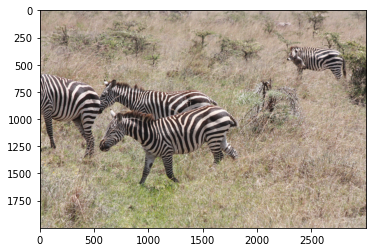

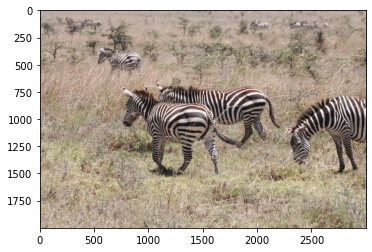

In [58]:
def to_coord_bbox(bbox):
    return [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]

# def to_coord_bbox(bbox):
#     return [bbox[1], bbox[0], bbox[1]+bbox[3], bbox[0]+bbox[2]]

def viz_edge(edge):
    (n0, n1, s) = edge
    uuid0 = node2uuid[n0]
    uuid1 = node2uuid[n1]
    data0 = filtered_df[filtered_df["uuid_x"]==uuid0].iloc[0]
    data1 = filtered_df[filtered_df["uuid_x"]==uuid1].iloc[0]

    file_path0 = data0["file_path"]
    bbox0 = to_coord_bbox(data0["bbox"])
    
    file_path1 = data1["file_path"]
    bbox1 = to_coord_bbox(data1["bbox"])
    print(bbox0)
    print(bbox1)
    print(file_path0)
    print(file_path1)
    img0 = Image.open(file_path0)#.crop(bbox0)
    img1 = Image.open(file_path1)#.crop(bbox1)
    plt.imshow(img0)
    plt.show()
    plt.imshow(img1)
    plt.show()
    
ind = 20
print(pos_edges[ind])
viz_edge(pos_edges[ind])
    

In [27]:
filtered_df

,uuid_x,image_uuid,bbox,theta,viewpoint,category_id,name,name_viewpoint,uuid_y,file_name,height,width,date_captured,name__viewpoint,name_id,file_path
0,34353f97-f1ce-4b45-913f-0edf0d6dd404,4648c253-7453-40fb-9eb0-f732dd0950e3,"[465.8203125, 703.125, 884.765625, 817.3828125]",0.0,left,1,IBEIS_PZ_0002,IBEIS_PZ_0002-left,4648c253-7453-40fb-9eb0-f732dd0950e3,000000003619.jpg,2250,3000,2015-02-18 20:09:17,IBEIS_PZ_0002_left,0,/ekaterina/work/data/plain_zebra/images/train2...
1,376ee34b-dc81-4e8e-828a-daa9ec27dfec,4c19e4ac-b4fa-43df-a54e-fbdec4fb7bd7,"[1954.3539325842698, 602.5280898876405, 1032.3...",0.0,left,1,IBEIS_PZ_0003,IBEIS_PZ_0003-left,4c19e4ac-b4fa-43df-a54e-fbdec4fb7bd7,000000004212.jpg,2000,3000,2015-02-25 10:35:28,IBEIS_PZ_0003_left,1,/ekaterina/work/data/plain_zebra/images/train2...
2,131a4d6d-cf66-42e0-9607-7af2c246812a,38132b53-90d7-4235-ba4e-8207ba724c8f,"[1362.3046875, 436.5234375, 656.25, 717.7734375]",0.0,left,1,IBEIS_PZ_0003,IBEIS_PZ_0003-left,38132b53-90d7-4235-ba4e-8207ba724c8f,000000003615.jpg,2250,3000,2015-02-18 20:06:50,IBEIS_PZ_0003_left,1,/ekaterina/work/data/plain_zebra/images/train2...
3,456ca345-8d9f-4b18-83fb-116768abf68f,8e97bbbb-63a9-41c0-a62a-1a178dc5da31,"[1270.3651685393259, 813.9044943820226, 403.79...",0.0,left,1,IBEIS_PZ_0007,IBEIS_PZ_0007-left,8e97bbbb-63a9-41c0-a62a-1a178dc5da31,000000004117.jpg,2000,3000,2015-02-25 09:52:12,IBEIS_PZ_0007_left,2,/ekaterina/work/data/plain_zebra/images/train2...
4,3d0b1e65-60c2-4e4a-899f-46d3e866b697,286765c4-8d7e-4511-a0a1-f5ed7377a4d8,"[1932.4162679425835, 688.9952153110048, 481.75...",0.0,left,1,IBEIS_PZ_0008,IBEIS_PZ_0008-left,286765c4-8d7e-4511-a0a1-f5ed7377a4d8,000000003537.jpg,1995,3000,2015-02-18 19:53:47,IBEIS_PZ_0008_left,3,/ekaterina/work/data/plain_zebra/images/train2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,a2bdeada-6e0f-40c9-b8fd-3450833eb8f8,876617b8-c13b-438e-bb7f-426e72f71936,"[1744.0, 737.0, 767.0, 552.5]",0.0,left,1,IBEIS_PZ_1871,IBEIS_PZ_1871-left,876617b8-c13b-438e-bb7f-426e72f71936,000000002749.jpg,2000,3000,2015-03-02 17:25:00,IBEIS_PZ_1871_left,502,/ekaterina/work/data/plain_zebra/images/train2...
741,a5387552-47dc-4a23-9c7a-3374ad2648f3,fc7de7db-d1ed-4da1-aaad-3742777b8e4d,"[2416.801948051948, 158.27922077922076, 578.32...",0.0,left,1,IBEIS_PZ_1894,IBEIS_PZ_1894-left,fc7de7db-d1ed-4da1-aaad-3742777b8e4d,000000001312.jpg,1987,3000,2015-03-01 15:05:27,IBEIS_PZ_1894_left,503,/ekaterina/work/data/plain_zebra/images/train2...
742,731e1f66-5100-4ec8-b3ec-36e18113413c,bf749000-6054-49ce-bcb8-93aaa6f8ffa4,"[968.3988764044944, 740.870786516854, 1036.516...",0.0,left,1,IBEIS_PZ_1894,IBEIS_PZ_1894-left,bf749000-6054-49ce-bcb8-93aaa6f8ffa4,000000000890.jpg,2000,3000,2015-03-01 14:20:52,IBEIS_PZ_1894_left,503,/ekaterina/work/data/plain_zebra/images/train2...
743,48d23b23-c1ce-487e-90e2-c2bd79a24a0e,8f12d852-324e-4c27-9277-9dde192b3af7,"[1606.7708333333333, 651.0416666666666, 591.14...",0.0,left,1,IBEIS_PZ_1905,IBEIS_PZ_1905-left,8f12d852-324e-4c27-9277-9dde192b3af7,000000000495.jpg,2250,3000,2015-03-01 11:30:29,IBEIS_PZ_1905_left,504,/ekaterina/work/data/plain_zebra/images/train2...
